In [59]:
using PyPlot, JLD2, LinearAlgebra

include("code/acoustic_solver_parallel.jl")
include("code/adjoint_method.jl")
include("code/optimization.jl")

update_fn (generic function with 1 method)

In [3]:
# load data
@load "marmousi_model/marmousi_model_for_ex4.jld2"

5-element Array{Symbol,1}:
 :c
 :c_true
 :rho
 :rho_true
 :h

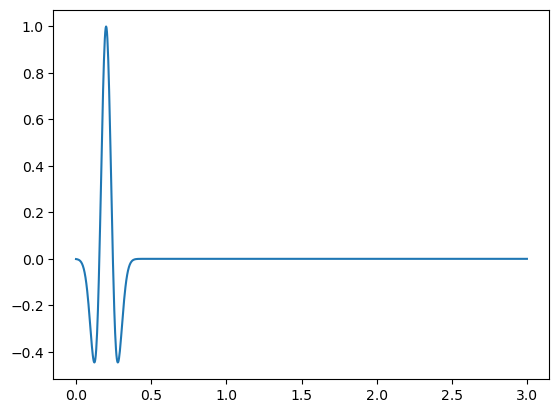

Nx: 117. Ny: 301. Nt:1050
Source number: 11
Receiver number: 101
CFL: 0.4476190294538226


In [7]:
Nx, Ny = size(c_true)

# time
Fs = 350;
dt = 1/Fs;
Nt = 1050;
t = range(0,length=Nt,step=dt);

# source
source = source_ricker(5,0.2,t)
source_num = 11
source_position = zeros(Int,source_num,2)
for i = 1:source_num
        source_position[i,:] = [1 1+30(i-1)]
end
source = repeat(source, 1, 1);

# receiver
receiver_num = 101
receiver_position = zeros(Int,receiver_num,2)
for i = 1:receiver_num
    receiver_position[i,:] = [1, (i-1)*3+1]
end

# PML
pml_len = 30
pml_coef = 50;

plot(t, source[:,1])

println("Nx: ", Nx, ". Ny: ", Ny, ". Nt:", Nt)
println("Source number: ", source_num)
println("Receiver number: ", receiver_num)
println("CFL: ", maximum(c_true) * dt / h);
println("===============================================")

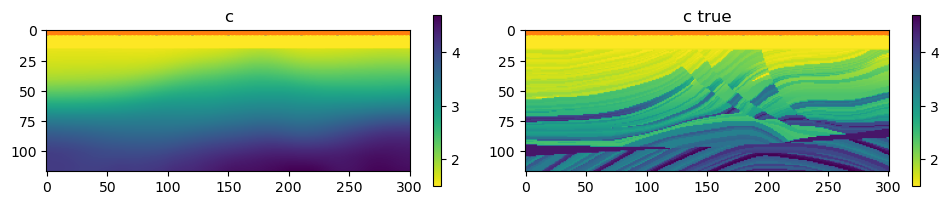

In [15]:
figure(figsize=(10,6))

cmap_name = "viridis_r"
subplot(121); imshow(c, cmap=cmap_name); title("c"); colorbar(shrink=0.3); clim(minimum(c_true),maximum(c_true))
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1)

subplot(122); imshow(c_true, cmap=cmap_name); title("c true"); colorbar(shrink=0.3); clim(minimum(c_true),maximum(c_true))
scatter(source_position[:,2].-1, source_position[:,1].-1)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1)

tight_layout()

In [27]:
# make data
println("Computing received data.")
@time received_data = multi_solver_no_wavefield(c_true, rho_true, Nx, h, Ny, h, Nt, dt, source, source_position, receiver_position; pml_len=pml_len, pml_coef=pml_coef);
println("Received data done.")

Computing received data.
 18.167238 seconds (180.84 k allocations: 146.064 MiB, 0.27% gc time)
Received data done.


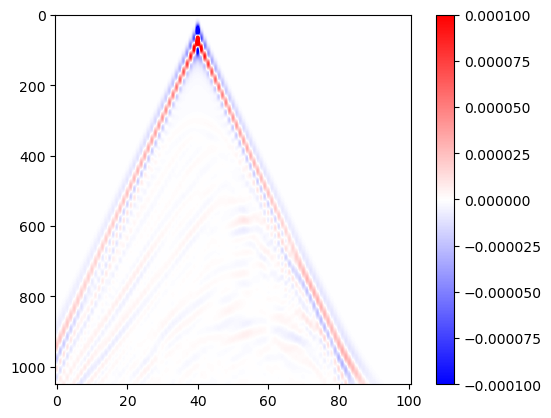

In [26]:
imshow(received_data[:,:,5], cmap="bwr", aspect=0.1); colorbar(); clim(-0.0001,0.0001)

## Test computing adjoint source 

In [28]:
# make data
ind = 6
println("Computing received data.")
@time u, data_forward = acoustic_solver(c, rho, Nx, h, Ny, h, Nt, dt, source, source_position[ind,:]', receiver_position; pml_len=pml_len, pml_coef=pml_coef)
println("Received data done.")

Computing received data.
  3.426563 seconds (1.78 M allocations: 373.075 MiB, 4.97% gc time)
Received data done.


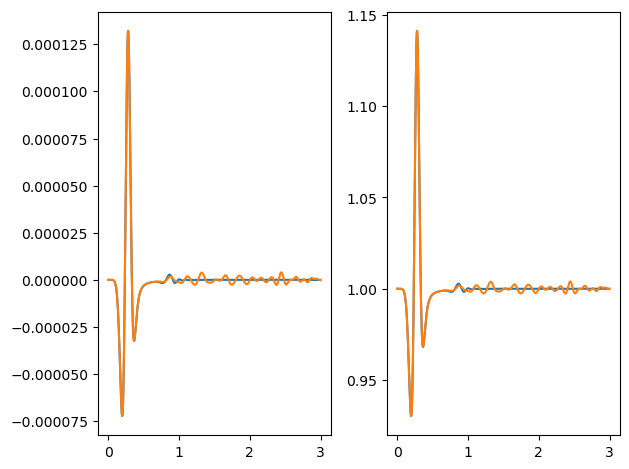

In [88]:
i = 50
eps = 1e-5
lambda_mix = 1e-10
M = cost_matrix_1d(t, t; p=2)
iteration_number = 500
k_normalize = 1e3

b = received_data[:,i,ind]
a = data_forward[:,i]

a_exp = exp.(k_normalize .* a)
b_exp = exp.(k_normalize .* b)

subplot(121)
plot(t, a, t, b)
subplot(122)
plot(t, a_exp, t, b_exp)

tight_layout()

In [89]:
@time adj_s = adj_source_mixed_tbyt(data_forward, received_data[:,:,6], eps, lambda_mix, M, k_normalize; iter_num=iteration_number);



 25.693118 seconds (467.85 k allocations: 6.052 GiB, 3.77% gc time)


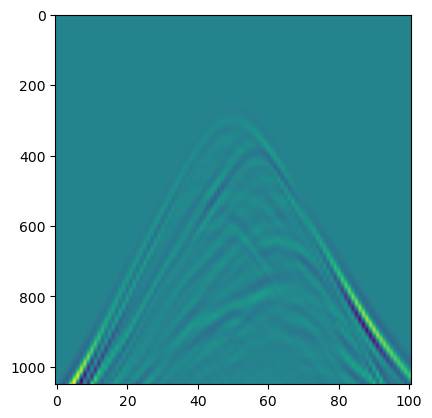

PyObject <matplotlib.image.AxesImage object at 0x7fd20b9a1700>

In [90]:
imshow(data_forward - received_data[:,:,6], aspect=0.1)

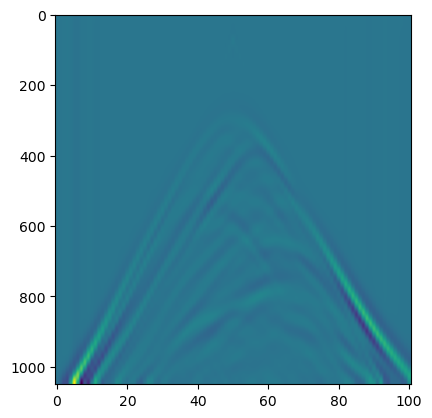

PyObject <matplotlib.image.AxesImage object at 0x7fd20b687850>

In [91]:
imshow(adj_s[2], aspect=0.1)

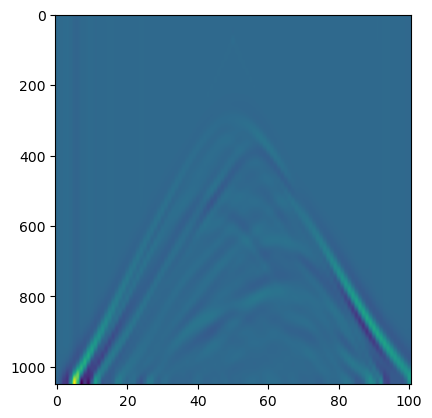

PyObject <matplotlib.image.AxesImage object at 0x7fd388a4d0a0>

In [51]:
imshow(adj_s[2], aspect=0.1)

In [103]:
eps = 1e-5
lambda_mix = 1e-10
M = cost_matrix_1d(t, t; p=2)
iteration_number = 1000
k_normalize = 5e3

compute_adj_source_mixed_tbyt(data_forward, received_data) = adj_source_mixed_tbyt(data_forward, received_data, eps, lambda_mix, M, k_normalize; iter_num=iteration_number)

eval_fn_ot(x) = eval_obj_fn_mixed_exp(received_data, x, rho, Nx, h, Ny, h, Nt, dt, source, source_position, receiver_position, compute_adj_source_mixed_tbyt; pml_len=30, pml_coef=50)

eval_grad_ot(x) = compute_gradient_mixed_exp_cutoff(received_data, x, rho, Nx, h, Ny, h, Nt, dt, source, source_position, receiver_position, compute_adj_source_mixed_tbyt; pml_len=30, pml_coef=50)



eval_grad_ot (generic function with 1 method)

In [104]:
@time ddd, gg_ott = eval_grad_ot(c);

626.256594 seconds (9.56 M allocations: 87.292 GiB, 2.48% gc time)


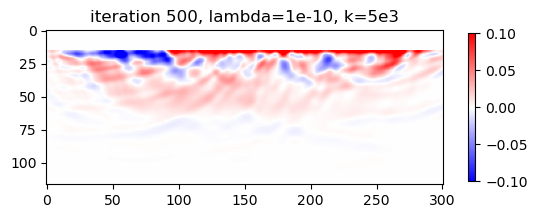

PyObject Text(0.5, 1.0, 'iteration 500, lambda=1e-10, k=5e3')

In [108]:
imshow(5e11 * reshape(gg_ott,Nx,Ny), cmap="bwr"); colorbar(shrink=0.4); clim(-0.1,0.1); title("iteration 500, lambda=1e-10, k=5e3")

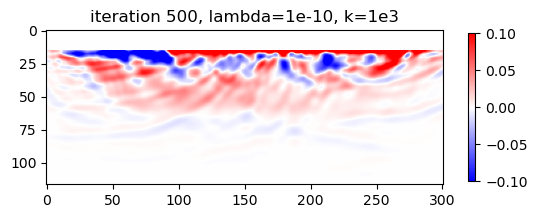

PyObject Text(0.5, 1.0, 'iteration 500, lambda=1e-10, k=1e3')

In [96]:
imshow(5e12 * reshape(gg_ott,Nx,Ny), cmap="bwr"); colorbar(shrink=0.4); clim(-0.1,0.1); title("iteration 500, lambda=1e-10, k=1e3")

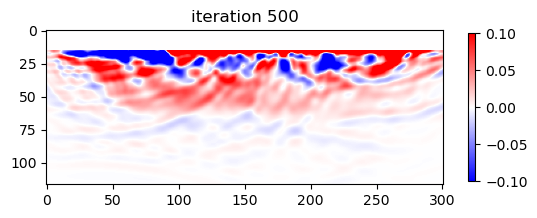

PyObject Text(0.5, 1.0, 'iteration 500')

In [79]:
imshow(8e12 * reshape(gg_ott,Nx,Ny), cmap="bwr"); colorbar(shrink=0.4); clim(-0.1,0.1); title("iteration 500")